In [24]:
import os
import glob
import unicodedata
import string

import random

import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

## Loadin Data

In [2]:
find_files = lambda path: glob.glob(path)

In [3]:
all_letters = string.ascii_letters + " .,;'"  #2* 26(Both lowercase and uppercase letters) + [space . , : ']
n_letters = len(all_letters)
n_letters

57

In [4]:
#function to convert unicode to ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [5]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
category_lines = {} #dictionary {'language name': names} eg. {'German': list(German names)}
all_categories = [] #list of class names (languages)

In [7]:
def read_lines(filename):
    '''Function to read a file and return list of names in the file'''
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [8]:
for filename in find_files('data/names/*.txt'):                 #loop over each file in directory
    category = os.path.splitext(os.path.basename(filename))[0]  #extract the filename i.e., the language name
    all_categories.append(category)                             #append the language name to the list
    names = read_lines(filename)                                #get all the names in the file
    category_lines[category] = names                            #store them in the dictionary

In [9]:
n_categories = len(all_categories)

In [10]:
print(category_lines.get('German')[:5])

['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']


## Converting data to Tensor

In [11]:
#function to find index of a character
letterToIndex = lambda letter: all_letters.find(letter)

In [14]:
letterToIndex('a'), letterToIndex('M')

(0, 38)

In [15]:
# Turn a name into a <name_length x 1 x n_letters> tensor,
# or a tensor of one-hot vector of letters of the name
def lineToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [16]:
print(lineToTensor('Mohan').size())

torch.Size([5, 1, 57])


## Model

In [17]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self):
        #initializing hidden state as a tensor of zeros
        hidden = torch.zeros((1,hidden_size), dtype=torch.float32)
        return hidden
        
    def forward(self, x, hidden):
        combined_input = torch.cat((x, hidden), 1) #concatenating inputs
        
        linear_comb = self.i2h(combined_input)
        
        hidden = torch.tanh(linear_comb)  #updating hidden state
        
        out = self.h2o(hidden)    #calculationg output
        out = self.softmax(out)
        return out, hidden

In [18]:
input_size = n_letters
hidden_size = 128
output_size = n_categories

In [19]:
rnn = RNN(input_size, hidden_size, output_size)

In [17]:
#defining loss function
criterion = nn.NLLLoss()

In [18]:
learning_rate = 0.001

### Verifying if the model has no errors

In [20]:
input_x = lineToTensor('Mohan')

In [21]:
hidden = rnn.init_hidden()
output, next_hidden = rnn(input_x[0], hidden)
print(output)

tensor([[-2.9626, -2.9779, -2.8675, -2.9573, -2.9451, -2.8760, -3.0003, -2.9055,
         -2.9193, -2.7723, -2.9196, -2.9030, -2.9330, -2.8280, -2.8157, -2.8039,
         -2.7836, -2.8960]], grad_fn=<LogSoftmaxBackward0>)


In [22]:
def categoryFromOutput(output):
    '''Function to get the name of language from the output of the model'''
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    
    return all_categories[category_i], category_i

In [23]:
print(categoryFromOutput(output))

('Italian', 9)


In [25]:
def randomChoice(class_names):
    '''Function to return random name  from the class names'''
    return class_names[random.randint(0, len(class_names) - 1)]

In [27]:
randomChoice(all_categories)

'Czech'

In [28]:
def randomTrainingExample():
    '''Function to generate random training example'''
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Thien
category = Chinese / line = Jin
category = Polish / line = Sokal
category = Czech / line = Dolezal
category = Chinese / line = Lim
category = Scottish / line = Ross
category = Dutch / line = Penner
category = Portuguese / line = Pinheiro
category = German / line = Vieth
category = Greek / line = Taflambas


In [29]:
def train_one_step(name_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    rnn.zero_grad()
    
    #Forward pass for one name
    for i in range(name_tensor.shape[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    #updating parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

In [ ]:
epochs = 100000
print_every = 5000
plot_every = 1000

In [ ]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

In [ ]:
def timeSince(start):
    '''Function to track time since start'''
    now = time.time()
    s = now - start
    m = s // 60
    s -= m * 60
    return '%dm %ds' % (m, s)

In [24]:
start = time.time()

for iter in range(1, epochs + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train_one_step(name_tensor, category_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        pred, pred_i = categoryFromOutput(output)
        correct = '✓' if pred == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / epochs * 100, timeSince(start), loss, name, pred, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.9167 Chong / Chinese ✗ (Korean)
10000 10% (0m 19s) 2.6962 Nishikawa / Japanese ✓
15000 15% (0m 29s) 2.6979 Wirnhier / German ✓
20000 20% (0m 39s) 2.4694 Mulenkov / Russian ✓
25000 25% (0m 49s) 2.2016 Jing / Chinese ✓
30000 30% (1m 0s) 2.1968 Ferro / Portuguese ✓
35000 35% (1m 10s) 2.3945 Martin / Irish ✗ (Scottish)
40000 40% (1m 21s) 1.2728 Shadid / Arabic ✓
45000 45% (1m 30s) 2.5528 Daly / Vietnamese ✗ (Irish)
50000 50% (1m 41s) 1.9371 Santos / Greek ✗ (Portuguese)
55000 55% (1m 50s) 2.9163 Katz / Japanese ✗ (German)
60000 60% (2m 1s) 2.3359 Safko / Japanese ✗ (Czech)
65000 65% (2m 11s) 1.5845 Blaise / French ✓
70000 70% (2m 22s) 1.7109 Bach / Vietnamese ✓
75000 75% (2m 33s) 2.8624 Vogts / Portuguese ✗ (German)
80000 80% (2m 43s) 1.0248 Mochan / Irish ✓
85000 85% (2m 55s) 2.4892 Docherty / Irish ✗ (Scottish)
90000 90% (3m 7s) 1.2896 Zhaboev / Russian ✓
95000 95% (3m 18s) 0.1485 Crocetti / Italian ✓
100000 100% (3m 30s) 1.7219 Danas / Arabic ✗ (Greek)


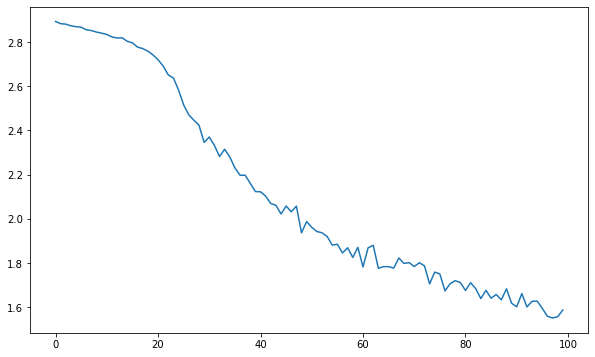

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(10,6))
plt.plot(all_losses)
plt.show()

## Prediction

In [26]:
def evaluate(name_tensor):
    hidden = rnn.init_hidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

In [27]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.93) Russian
(-1.19) Polish
(-1.92) Czech

> Jackson
(-1.17) Scottish
(-1.29) Russian
(-2.25) English

> Satoshi
(-1.01) Polish
(-1.35) Italian
(-1.58) Japanese


Reference: [Pytorch documentation](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial)